In [51]:
import bnlearn as bn
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
model = bn.import_DAG("asia")

[bnlearn] >Loading bif file <D:\edu\anaconda\envs\bayes\lib\site-packages\bnlearn\data\ASIA/asia.bif>
[bnlearn] >Checking CPDs..
[bnlearn] >Check for DAG structure. Correct: True


[bnlearn] >Plot based on BayesianModel


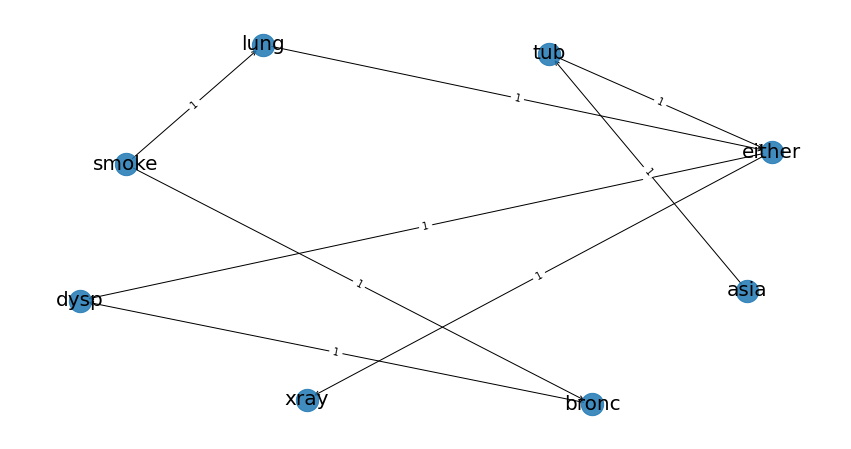

{'pos': {'asia': array([ 0.90840992, -0.34113526]),
  'tub': array([0.34216636, 0.91365797]),
  'smoke': array([-0.86831882,  0.32781186]),
  'lung': array([-0.47527141,  0.96109458]),
  'bronc': array([ 0.46521503, -0.94235906]),
  'either': array([0.97901619, 0.39375172]),
  'xray': array([-0.35121726, -0.91841459]),
  'dysp': array([-1.        , -0.39440723])},
 'G': <networkx.classes.digraph.DiGraph at 0x23e2b6d8f10>}

In [4]:
bn.plot(model)

In [5]:
bn.print_CPD(model)

CPD of asia:
+---------+------+
| asia(0) | 0.01 |
+---------+------+
| asia(1) | 0.99 |
+---------+------+
CPD of bronc:
+----------+----------+----------+
| smoke    | smoke(0) | smoke(1) |
+----------+----------+----------+
| bronc(0) | 0.6      | 0.3      |
+----------+----------+----------+
| bronc(1) | 0.4      | 0.7      |
+----------+----------+----------+
CPD of dysp:
+---------+-----------+-----------+-----------+-----------+
| bronc   | bronc(0)  | bronc(0)  | bronc(1)  | bronc(1)  |
+---------+-----------+-----------+-----------+-----------+
| either  | either(0) | either(1) | either(0) | either(1) |
+---------+-----------+-----------+-----------+-----------+
| dysp(0) | 0.9       | 0.8       | 0.7       | 0.1       |
+---------+-----------+-----------+-----------+-----------+
| dysp(1) | 0.1       | 0.2       | 0.3       | 0.9       |
+---------+-----------+-----------+-----------+-----------+
CPD of either:
+-----------+---------+---------+---------+---------+
| lung     

In [63]:
def get_prob(model, fixed_values, sampling=False):
    cpds = model['model'].get_cpds()
    if sampling:
        ok = 0
        results = []
        order = bn.topological_sort(model)
        for i in range(40000):
            values = {}
            for name in order:
                cpd = model['model'].get_cpds(name)
                args = cpd.variables
                probs = []
                if len(args) == 1:
                    probs = cpd.values
                else:
                    probs = [0 for _ in range(cpd.variable_card)]
                    for j in range(cpd.variable_card):
                        p = cpd.values[j]
                        for var_name in args[1:]:
                            p = p[values[var_name]]
                        probs[j] = p
                values[name] = random.choices([j for j in range(cpd.variable_card)], probs)[0]
            sample = 1
            for name, val in fixed_values.items():
                if values[name] != val:
                    sample = 0
                    break
            ok += sample
            if (i % 100 == 0):
                results.append(ok / (i + 1))
        return results[-1], results       
    else:
        all_variables = []
        names = []
        for cpd in cpds:
            names.append(cpd.variable)
            if cpd.variable in fixed_values:
                all_variables.append(np.array([fixed_values[cpd.variable]]))
            else:
                all_variables.append(np.arange(0, cpd.variable_card, 1))
        all_combinations = np.array(np.meshgrid(*all_variables)).T.reshape(-1, len(cpds))

        final_prob = 0.
        for comb in all_combinations:
            prob = 1.
            for cpd in cpds:
                p = cpd.values
                for name in cpd.variables:
                    p = p[comb[names.index(name)]]
                prob *= p
            final_prob += prob
        return final_prob

In [64]:
fixed = {'lung':1, 'bronc':0, 'tub':1, 'smoke':1}
real_prob = get_prob(model, fixed, False)
sampled_prob, probs = get_prob(model, fixed, True)

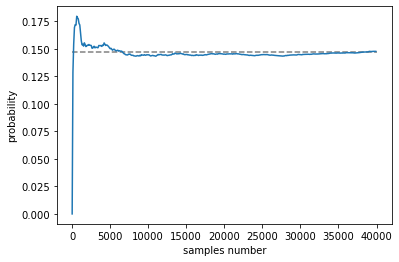

In [66]:
plt.xlabel('samples number')
plt.ylabel('probability')
plt.plot([i for i in range(0, 40000, 100)], probs)
plt.hlines(real_prob, 0, 40000, color='grey', linestyle='dashed')
plt.show()